# Use of Measured Aerosol Optical Depth and Precipitable Water to Model Clear Sky Irradiance
*presented at: 2017 IEEE PVSC-44*
*by: Mark A. Mikofski, Clifford W. Hansen, William F. Holmgren and Gregory M. Kimball*

## Introduction
Predicting irradiance is crucial for developing solar power systems. Clear sky models are used to predict irradiance based on solar position and atmospheric data. This paper compares clear sky predictions using atmospheric data from ECMWF with irradiance measurments from SURFRAD. This notebook presents the analysis for the paper and presentation given by the authors at the 2017 IEEE PVSC-44 in Washingtion DC June 25-30th.

## How to use this Jupyter notebook
This document is a [Jupyter notebook](http://jupyter.org/). It can be used several different ways. You can [view the notebook as a static HTML document](http://nbviewer.jupyter.org/github/mikofski/pvsc44-clearsky-aod/blob/master/PVSC-Clearsky-AOD.ipynb). You can also [clone the repository from GitHub using Git](https://github.com/mikofski/pvsc44-clearsky-aod), install [the requirements](https://github.com/mikofski/pvsc44-clearsky-aod/blob/master/requirements.txt) in a [Python virtual environment](https://virtualenv.pypa.io/en/stable/) and run the notebook interactively using [Python](https://www.python.org/).

## PVLIB-Python
This analysis uses Sandia National Laboratory's PVLIB-Python software extensively. PVLIB-Python is a library of functions for modeling photovoltaic devices, irradiance and atmospheric conditions. The [documentation for PVLIB-Python](http://pvlib-python.readthedocs.io/en/latest/) is online and there is more information at the [Sandia PV Performance Model Collaborative](https://pvpmc.sandia.gov/).

In [1]:
# imports and settings
import os

import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import seaborn as sns
import statsmodels.api as sm

from pvsc44_clearsky_aod import ecmwf_macc_tools

%matplotlib inline

sns.set_context('notebook', rc={'figure.figsize': (8, 6)})
sns.set(font_scale=1.5)

c:\python27\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data
Two sources of data are used in this analysis, SURFRAD and ECMWF, each described in the following sections.

### SURFRAD
[SURFRAD data from NOAA](https://www.esrl.noaa.gov/gmd/grad/surfrad/) contains irradiance measurements at sub-hour increments from seven stations accross the United States. The data can be viewed online or downloaded from a NOAA FTP site <ftp://aftp.cmdl.noaa.gov/data/radiation/surfrad/>. Data is organized into folders for each station and yearly subfolders containing individual daily files. The `README` in each station's folder provides additional information such as the format of the files, types of data in each column, definitions, and abbreviations. The first two rows of each daily file contains header information about the file. The first line is the station name and the second line contains the latitude, longitude and elevation. Data is timestamped at the beginning of each interval. Starting around 2008, most sites increased sampling to 1-minute intervals, other years sampled at 3-minute intervals. The irradiance data includes direct (DNI), diffuse (DHI), and downwelling solar irradiance which is equivalent global horizontal irradiance (GHI). Units of irradiance are W/m<sup>2</sup>. Ambient temperature is given in Celsius, pressure in millibars and relative humidity in percent.

There are seven sites with data that overlaps the time span of the atmospheric data (see the next section). The following metadata was collected from the daily data files, which all contain the same header for each site, and the `README`.

|station id |UTC offset |timezone   |station name  |City             |latitude |longitude |elevation |
|-----------|-----------|-----------|--------------|-----------------|---------|----------|----------|
|bon        |-6.0       |US/Central |     Bondville|Bondville, IL    |    40.05|    -88.37|       213|
|tbl        |-7.0       |US/Mountain|Table Mountain|Boulder, CO      |    40.13|   -105.24|      1689|
|dra        |-8.0       |US/Pacific |   Desert Rock|Desert Rock, NV  |    36.62|   -116.02|      1007|
|fpk        |-7.0       |US/Mountain|     Fort Peck|Fort Peck, MT    |    48.31|   -105.10|       634|
|gwn        |-6.0       |US/Central | Goodwin Creek|Goodwin Creek, MS|    34.25|    -89.87|        98|
|psu        |-5.0       |US/Eastern |    Penn State|Penn State, PA   |    40.72|    -77.93|       376|
|sxf        |-6.0       |US/Central |   Sioux Falls|Sioux Falls, SD  |    43.73|    -96.62|       473|

There are three additional sites, Alamosa-CO, Red Lake-AZ, Rutland-VT, and Wasco-OR, that don't have data that cover the same 10 years span of the atmospheric data. Since SURFRAD also contains some atmospheric data, perhaps we can return to examine these sites later.

The SURFRAD data we used is shared as [`surfrad.zip` in a Public OneDrive folder](https://1drv.ms/u/s!Aqpq8OMJNa1PgSIiXyurr2_eHe0x). The zip file contains separate `CSV` files for each site and year, but only the timestamps, solar irradiances, ambient temperature, RH and pressure columns are preserved. This notebook assumes the files have been extracted to a folder in this directory called `surfrad`.

In [2]:
# get the "metadata" that contains the timezone, latitude, longitude, elevation and station id for SURFRAD
METADATA = pd.read_csv('metadata.csv', index_col=0)

In [3]:
# get SURFRAD data
station_id = 'bon'  # choose a station ID from the metadata list

# CONSTANTS
DATADIR = 'surfrad'  # folder where SURFRAD data is stored relative to this file
NA_VAL = '-9999.9'  # value SURFRAD uses for missing data
USECOLS = [0, 6, 7, 8, 9, 10, 11, 12]  # omit 1:year, 2:month, 3:day, 4:hour, 5:minute and 13:jday columns

# read 2003 data for the station, use first column as index, parse index as dates, and replace missing values with NaN
DATA = pd.read_csv(
    os.path.join(DATADIR, '%s03.csv' % station_id),
    index_col=0, usecols=USECOLS, na_values=NA_VAL, parse_dates=True
)

# append the data from 2003 to 2012 which coincides with the ECMWF data available
for y in xrange(2004, 2013):
    DATA = DATA.append(pd.read_csv(
        os.path.join(DATADIR, '%s%s.csv' % (station_id, str(y)[-2:])),
        index_col=0, usecols=USECOLS, na_values=NA_VAL, parse_dates=True
    ))

DATA['press'] = DATA['press'] * 100.0  # convert mbars to Pascals
DATA.index.rename('timestamps', inplace=True)  # rename the index to "timestamps"
DATA = DATA.tz_localize('UTC')  # set timezone to UTC

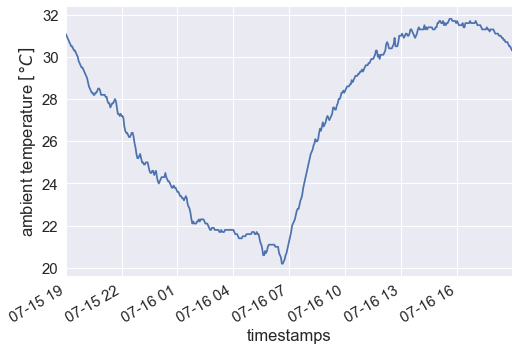

In [4]:
# plot some temperatures
DATA['ta']['2006-07-16T00:00:00':'2006-07-16T23:59:59'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('ambient temperature $[\degree C]$')

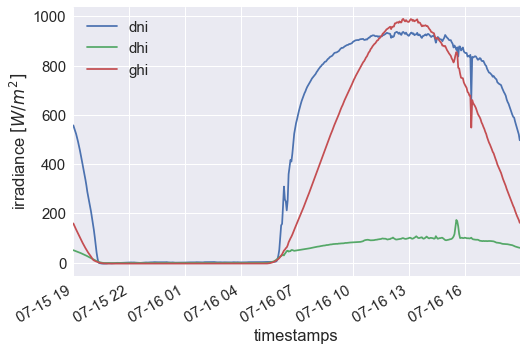

In [5]:
# plot some irradiance
DATA[['dni', 'dhi', 'ghi']]['2006-07-16T00:00:00':'2006-07-16T23:59:59'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('irradiance $[W/m^2]$')

### ECMWF
The [European Center for Medium Weather Forecast (ECMWF)](https://www.ecmwf.int/en/forecasts/datasets) hosts atmospheric data from [Monitoring Amospheric Composition & Climate (MACC)](http://www.gmes-atmosphere.eu/) and the [EU Copernicus Atmospheric Monitoring Service (CAMS)](http://atmosphere.copernicus.eu/). This data set contains aerosol optical depth (AOD) measured at several wavelengths and total column water vapor (_AKA_: precipitable water) data in centimeters (cm) derived from ground measurments and satelite data for the entire globe from 2003 to 2012. The [data can be downloaded online](http://apps.ecmwf.int/datasets/data/macc-reanalysis/levtype=sfc/) or from the [ECMWF API using the Python API client after registering for an API key](https://software.ecmwf.int/wiki/display/WEBAPI/Access+ECMWF+Public+Datasets). The downloaded data used in this analysis has spatial resolution of 0.75 &deg; x 0.75 &deg;. The timestamps are every 3-hours marked at the end of the measurement window - _EG_: each timestamp is the average over the preceeding interval.

In [4]:
# get AOD and water vapor for the SURFRAD station
ATMOS = ecmwf_macc_tools.Atmosphere()  # get the downloaded ECMWF-MACC data for the world

# create a datetime series for the ECMWF-MACC data, it's available from 2003 to 2012 in 3 hour increment
# pandas creates timestamps at the *beginning* of the each interval,shifting the timestamps from the end
# to match the SURFRAD data
TIMES = pd.DatetimeIndex(start='2003-01-01T00:00:00', freq='3H', end='2012-12-31T23:59:59').tz_localize('UTC')

# get the atmospheric data for the SURFRAD station as a pandas dataframe, and append some addition useful calculations
# like AOD at some other wavelengths (380-nm, 500-nm, and 700nm) and convert precipitable water to cm.
STATION_ATM = pd.DataFrame(
    ATMOS.get_all_data(METADATA['latitude'][station_id], METADATA['longitude'][station_id]), index=TIMES
)

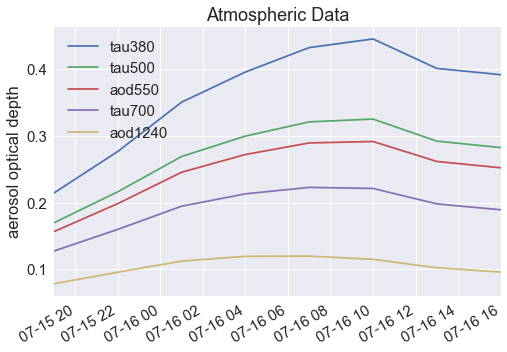

In [7]:
# plot some of the atmospheric data
atm_data = STATION_ATM[['tau380', 'tau500', 'aod550', 'tau700', 'aod1240']]['2006-07-13':'2006-07-17']
atm_data['2006-07-16T00:00:00':'2006-07-16T23:59:59'].tz_convert(METADATA['tz'][station_id]).plot()
plt.title('Atmospheric Data')
plt.ylabel('aerosol optical depth')
plt.savefig('%s_AOD_2006-07-16.png' % station_id)

### Solar Position, Airmass and Precipitable Water
NREL's Solar Position Algorithm (SPA) is used to find solar position including the effects of atmospheric refraction. The path length through the atmosphere or airmass is also calculated. Finally if water vapor measurements are not available, they can be estimated from relative humidity.

In [5]:
# solarposition, airmass, pressure-corrected & water vapor
SOLPOS = pvlib.solarposition.get_solarposition(
    time=DATA.index,
    latitude=METADATA['latitude'][station_id],
    longitude=METADATA['longitude'][station_id],
    altitude=METADATA['elevation'][station_id],
    pressure=DATA['press'],
    temperature=DATA['ta']
)
AIRMASS = pvlib.atmosphere.relativeairmass(SOLPOS.apparent_zenith)  # relative airmass
AM_PRESS = pvlib.atmosphere.absoluteairmass(AIRMASS, pressure=DATA['press'])  # pressure corrected airmass
PWAT_CALC = pvlib.atmosphere.gueymard94_pw(DATA['ta'], DATA['rh'])  # estimate of atmospheric water vapor in cm
ETR = pvlib.irradiance.extraradiation(DATA.index)  # extra-terrestrial total solar radiation

# append these to the SOLPOS dataframe to keep them together more easily
SOLPOS.insert(6, 'am', AIRMASS)
SOLPOS.insert(7, 'amp', AM_PRESS)
SOLPOS.insert(8, 'pwat_calc', PWAT_CALC)
SOLPOS.insert(9, 'etr', ETR)

c:\python27\lib\site-packages\pvlib\atmosphere.py:215: RuntimeWarning: invalid value encountered in power
  0.50572*(((6.07995 + (90 - z)) ** - 1.6364))))
c:\python27\lib\site-packages\pvlib\atmosphere.py:319: RuntimeWarning: invalid value encountered in maximum
  pw = np.maximum(pw, 0.1)


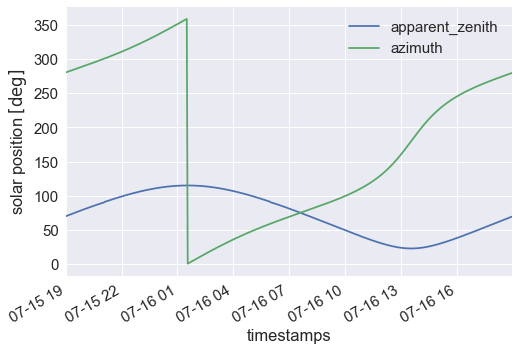

In [9]:
# plot solar position for a day
SOLPOS[['apparent_zenith', 'azimuth']]['2006-07-16T00:00:00':'2006-07-16T23:59:59'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('solar position $[\deg]$')

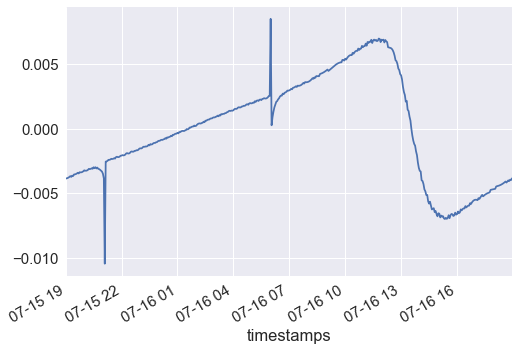

In [10]:
# compare calculated solar position to SURFRAD
(DATA['solzen'] / SOLPOS['apparent_zenith'] - 1)['2006-07-16T00:00:00':'2006-07-16T23:59:59'].tz_convert(METADATA['tz'][station_id]).plot()

In [6]:
# concatenate atmospheric parameters so they're the same size
# pd.concat fills missing timestamps from low frequency datasets with NaN
atm_params = pd.concat([DATA, STATION_ATM, SOLPOS], axis=1)

# then fill in NaN in atmospheric data by padding with the previous value
atm_params['alpha'].fillna(method='pad', inplace=True)
atm_params['aod1240'].fillna(method='pad', inplace=True)
atm_params['aod550'].fillna(method='pad', inplace=True)
atm_params['pwat'].fillna(method='pad', inplace=True)
atm_params['tau380'].fillna(method='pad', inplace=True)
atm_params['tau500'].fillna(method='pad', inplace=True)
atm_params['tau700'].fillna(method='pad', inplace=True)
atm_params['tcwv'].fillna(method='pad', inplace=True)

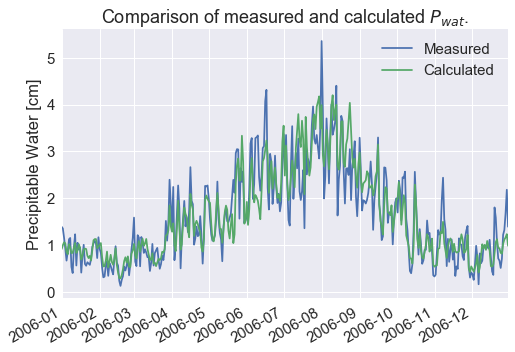

In [12]:
# compare measured and calculated precipitable water
# Pad the ECMWF-MACC data since it's at 3-hour intervals, but SURFRAD is at 1-minute or 3-minute intervals.
# Then rollup daily averages to make long term trends easier to see.
pwat = pd.concat([atm_params['pwat'], atm_params['pwat_calc']], axis=1).resample('D').mean()
pwat['2006-01-01':'2006-12-31'].tz_convert(METADATA['tz'][station_id]).plot()
plt.title('Comparison of measured and calculated $P_{wat}$.')
plt.ylabel('Precipitable Water [cm]')
plt.legend(['Measured', 'Calculated'])

### Linke Turbidity
Linke turbidity is an atmospheric parameter that combines AOD and P<sub>wat</sub>. A historical data set (_c_. 2003) is parameter in the Ineichen clearsky model.

In [7]:
# lookup Linke turbidity
# use 3-hour intervals to speed up lookup
LT = pvlib.clearsky.lookup_linke_turbidity(
    time=TIMES,
    latitude=METADATA['latitude'][station_id],
    longitude=METADATA['longitude'][station_id],
)

# calculate Linke turbidity using Kasten pyrheliometric formula
LT_CALC = pvlib.atmosphere.kasten96_lt(
    atm_params['amp'], atm_params['pwat'], atm_params['tau700']
)

# calculate broadband AOD using Bird & Hulstrom approximation
AOD_CALC = pvlib.atmosphere.bird_hulstrom80_aod_bb(atm_params['tau380'], atm_params['tau500'])

# recalculate Linke turbidity using Bird & Hulstrom broadband AOD
LT_AOD_CALC = pvlib.atmosphere.kasten96_lt(
    atm_params['amp'], atm_params['pwat'], AOD_CALC
)

In [8]:
# insert Linke turbidity to atmospheric parameters table
atm_params.insert(25, 'lt', LT)
atm_params.insert(26, 'lt_calc', LT_CALC)
atm_params.insert(27, 'lt_aod_calc', LT_AOD_CALC)
atm_params.insert(28, 'aod_calc', AOD_CALC)

# Linke turbidity should be continuous, it only depends on time
# fill in Linke turbidity by padding previous values
atm_params['lt'].fillna(method='pad', inplace=True)

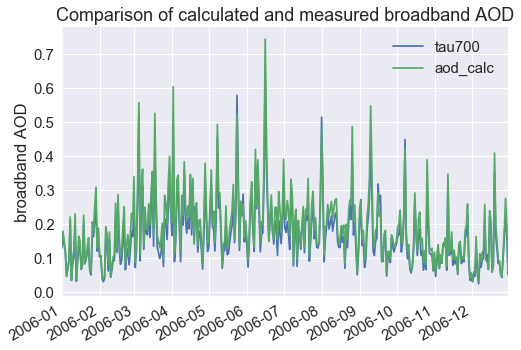

In [15]:
# compare Bird & Hulstrom approximated broadband AOD to AOD at 700-nm
# downsample to monthly intervals to show long term trend for entire range of ECMWF-MACC data
aod_bb = atm_params[['tau700', 'aod_calc']].resample('D').mean()
aod_bb['2006-01-01':'2006-12-31'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('broadband AOD')
plt.title('Comparison of calculated and measured broadband AOD')

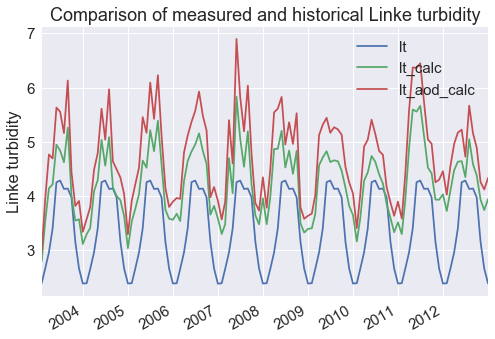

In [62]:
# compare historic Linke turbidity to calculated
# downsample to monthly averages to show long term trends
atm_params[['lt', 'lt_calc', 'lt_aod_calc']].resample('M').mean().tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('Linke turbidity')
plt.title('Comparison of measured and historical Linke turbidity')

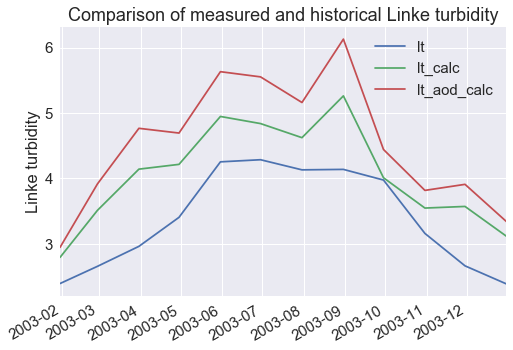

In [63]:
# compare historic Linke turbidity to calculated
# downsample to monthly averages to show long term trends
lt = atm_params[['lt', 'lt_calc', 'lt_aod_calc']].resample('M').mean()
lt['2003-01-01':'2003-12-31'].tz_convert(METADATA['tz'][station_id]).plot()
plt.ylabel('Linke turbidity')
plt.title('Comparison of measured and historical Linke turbidity')
plt.savefig('%s_Linke_turbidity_2003_monthly.png' % station_id)

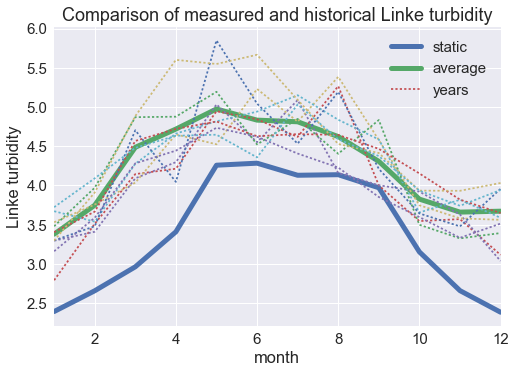

In [64]:
# compare historic Linke turbidity to calculated
# downsample to monthly averages to show long term trends
atm_params['lt'].tz_convert(METADATA['tz'][station_id]).groupby(lambda x: x.month).mean().plot(linewidth=5)
atm_params['lt_calc'].tz_convert(METADATA['tz'][station_id]).groupby(lambda x: x.month).mean().plot(linewidth=5)
for y in xrange(2003, 2013):
    lt = atm_params['lt_calc'][('%d-01-01' % y):('%d-12-31' % y)].tz_convert(METADATA['tz'][station_id]).groupby(lambda x: x.month).mean()
    lt.plot(linestyle=':')
plt.ylabel('Linke turbidity')
plt.xlabel('month')
plt.legend(['static', 'average', 'years'])
plt.title('Comparison of measured and historical Linke turbidity')
plt.savefig('%s_Linke_turbidity_allyears_monthly.png' % station_id)

In [17]:
# how is atmosphere changing over time?
# Calculate the linear regression of the relative difference between historical and measured Linke turbidity
lt_diff = (atm_params['lt_calc'] / atm_params['lt']).resample('A').mean() - 1.0  # yearly differences
x = np.arange(lt_diff.size)  # years
x = sm.add_constant(x)  # add y-intercept
y = lt_diff.values  # numpy array of yearly relative differences
results = sm.OLS(y, x).fit()  # fit linear regression
results.summary()  # output summary

c:\python27\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     6.966
Date:                Wed, 07 Jun 2017   Prob (F-statistic):             0.0297
Time:                        02:34:54   Log-Likelihood:                 18.332
No. Observations:                  10   AIC:                            -32.66
Df Residuals:                       8   BIC:                            -32.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2273      0.025      8.939      0.000       0.169       0.286
x1             0.0126      0.005      2.639      0.030       0.002       0.024
==============================================================================
Omnibus:                        2.472   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                0.719
Skew:                          -0.649   Prob(JB):                        0.698
Kurtosis:                       3.205   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

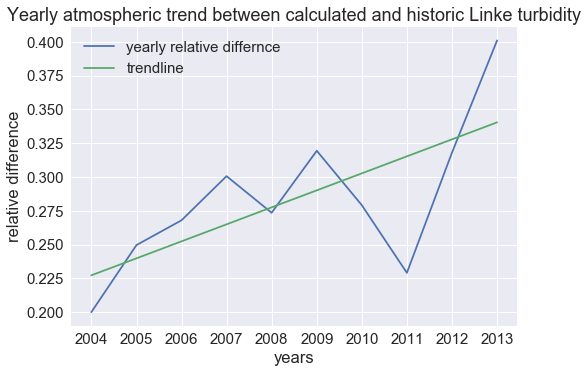

In [18]:
# plot yearly relative difference versus trendline
plt.plot(lt_diff)
plt.plot(lt_diff.index, results.fittedvalues)
plt.title('Yearly atmospheric trend between calculated and historic Linke turbidity')
plt.legend(['yearly relative differnce', 'trendline'])
plt.ylabel('relative difference')
plt.xlabel('years')
plt.savefig('%s_Linke_turbidity_trend.png' % station_id)

### Clear sky models
There are several clear sky models, and they take different arguments.

In [11]:
# calculate clear sky
INEICHEN_LT = pvlib.clearsky.ineichen(
    atm_params['apparent_zenith'], atm_params['amp'], atm_params['lt'], altitude=METADATA['elevation'][station_id],
    dni_extra=atm_params['etr']
)
INEICHEN_CALC = pvlib.clearsky.ineichen(
    atm_params['apparent_zenith'], atm_params['amp'], atm_params['lt_calc'], altitude=METADATA['elevation'][station_id],
    dni_extra=atm_params['etr']
)
INEICHEN_AOD_CALC = pvlib.clearsky.ineichen(
    atm_params['apparent_zenith'], atm_params['amp'], atm_params['lt_aod_calc'], altitude=METADATA['elevation'][station_id],
    dni_extra=atm_params['etr']
)
SOLIS = pvlib.clearsky.simplified_solis(
    atm_params['apparent_elevation'],
    atm_params['tau700'],
    atm_params['pwat'],
    pressure=atm_params['press'],
    dni_extra=atm_params['etr']
)
BIRD = pvlib.clearsky.bird(
    atm_params['apparent_zenith'],
    atm_params['am'],
    atm_params['tau380'],
    atm_params['tau500'],
    atm_params['pwat'],
    pressure=atm_params['press'],
    dni_extra=atm_params['etr']
)

c:\python27\lib\site-packages\pvlib\clearsky.py:113: RuntimeWarning: invalid value encountered in maximum
  cos_zenith = np.maximum(tools.cosd(apparent_zenith), 0)
c:\python27\lib\site-packages\pvlib\clearsky.py:126: RuntimeWarning: invalid value encountered in fmax
  ghi = cg1 * dni_extra * cos_zenith * tl / tl * np.fmax(ghi, 0)
c:\python27\lib\site-packages\pvlib\clearsky.py:131: RuntimeWarning: invalid value encountered in fmax
  bnci = dni_extra * np.fmax(bnci, 0)
c:\python27\lib\site-packages\pvlib\clearsky.py:136: RuntimeWarning: invalid value encountered in fmax
  bnci_2 = ghi * np.fmin(np.fmax(bnci_2, 0), 1e20)
c:\python27\lib\site-packages\pvlib\clearsky.py:138: RuntimeWarning: invalid value encountered in minimum
  dni = np.minimum(bnci, bnci_2)
c:\python27\lib\site-packages\pvlib\clearsky.py:418: RuntimeWarning: invalid value encountered in maximum
  sin_elev = np.maximum(1.e-30, np.sin(np.radians(apparent_elevation)))


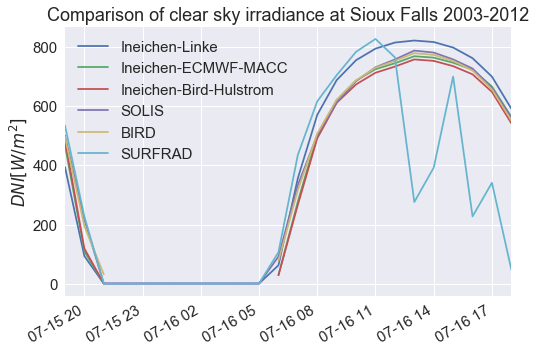

In [20]:
# plot direct normal irradiance
LEGEND = ['Ineichen-Linke', 'Ineichen-ECMWF-MACC', 'Ineichen-Bird-Hulstrom', 'SOLIS', 'BIRD', 'SURFRAD']
pd.concat([
    INEICHEN_LT['dni'], INEICHEN_CALC['dni'], INEICHEN_AOD_CALC['dni'],
    SOLIS['dni'], BIRD['dni'], atm_params['dni']
], axis=1)['2006-07-16T00:00:00':'2006-07-16T23:59:59'].resample('H').mean().tz_convert(METADATA['tz'][station_id]).plot()
plt.legend(LEGEND)
plt.title('Comparison of clear sky irradiance at %s 2003-2012' % METADATA['station name'][station_id])
plt.ylabel('$DNI [W/m^2]$')
plt.savefig('%s_DNI_2006-07-16.png' % station_id)

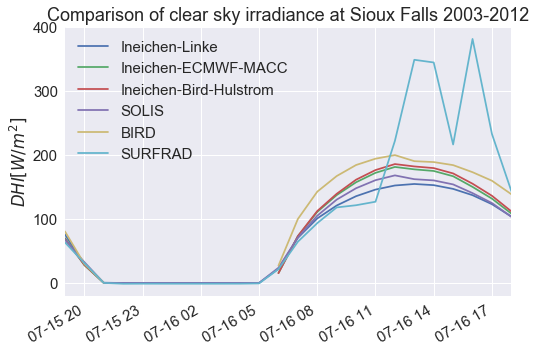

In [21]:
# plot diffuse irradiance
pd.concat([
    INEICHEN_LT['dhi'], INEICHEN_CALC['dhi'], INEICHEN_AOD_CALC['dhi'],
    SOLIS['dhi'], BIRD['dhi'], atm_params['dhi']
], axis=1)['2006-07-16T00:00:00':'2006-07-16T23:59:59'].resample('H').mean().tz_convert(METADATA['tz'][station_id]).plot()
plt.legend(LEGEND)
plt.title('Comparison of clear sky irradiance at %s 2003-2012' % METADATA['station name'][station_id])
plt.ylabel('$DHI [W/m^2]$')
plt.savefig('%s_DHI_2006-07-16.png' % station_id)

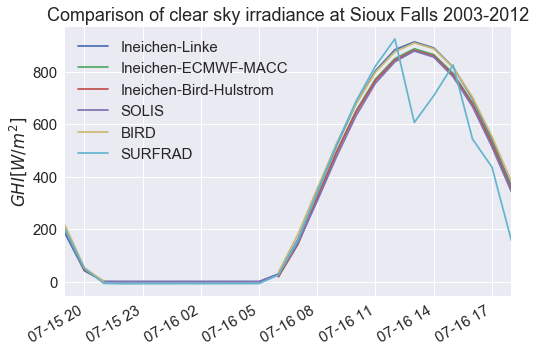

In [22]:
# plot global horizontal irradiance
pd.concat([
    INEICHEN_LT['ghi'], INEICHEN_CALC['ghi'], INEICHEN_AOD_CALC['ghi'],
    SOLIS['ghi'], BIRD['ghi'], atm_params['ghi']
], axis=1)['2006-07-16T00:00:00':'2006-07-16T23:59:59'].resample('H').mean().tz_convert(METADATA['tz'][station_id]).plot()
plt.legend(LEGEND)
plt.title('Comparison of clear sky irradiance at %s 2003-2012' % METADATA['station name'][station_id])
plt.ylabel('$GHI [W/m^2]$')
plt.savefig('%s_GHI_2006-07-16.png' % station_id)

In [12]:
# add clear sky calc to atmospheric parameters
atm_params.insert(29, 'solis_dhi', SOLIS['dhi'])
atm_params.insert(30, 'solis_dni', SOLIS['dni'])
atm_params.insert(31, 'solis_ghi', SOLIS['ghi'])
atm_params.insert(32, 'lt_dhi', INEICHEN_LT['dhi'])
atm_params.insert(33, 'lt_dni', INEICHEN_LT['dni'])
atm_params.insert(34, 'lt_ghi', INEICHEN_LT['ghi'])
atm_params.insert(35, 'macc_dhi', INEICHEN_CALC['dhi'])
atm_params.insert(36, 'macc_dni', INEICHEN_CALC['dni'])
atm_params.insert(37, 'macc_ghi', INEICHEN_CALC['ghi'])
atm_params.insert(38, 'bird_dhi', BIRD['dhi'])
atm_params.insert(39, 'bird_dni', BIRD['dni'])
atm_params.insert(40, 'bird_ghi', BIRD['ghi'])

# make even intervals at 1-minute and 3-minutes
atm_params_3min = atm_params.resample('3T').mean() # down using averages
atm_params_1min = atm_params.resample('T').pad() # up padding previous value

# add columns for year and month for pivot and groupby plots
atm_params_3min.insert(0, 'month', atm_params_3min.index.month)
atm_params_3min.insert(0, 'year', atm_params_3min.index.year)

## Detect Clear Sky
To compare the different models and the effects of historical versus measured atmospheric data, filter out any timestamps with clouds and low irradiance using `pvlib.clearsky.detect_clearsky()`.

In [13]:
# detect clear sky indices

# 1-minute data with 10-minute window
is_clear_1min = pvlib.clearsky.detect_clearsky(atm_params_1min['ghi'], atm_params_1min['solis_ghi'], atm_params_1min.index, 10)
# 3-minute data with 30 minute window
is_clear_3min = pvlib.clearsky.detect_clearsky(atm_params_3min['ghi'], atm_params_3min['solis_ghi'], atm_params_3min.index, 10)

# filter out low light
is_bright = atm_params_3min['ghi'] > 200

c:\python27\lib\site-packages\pvlib\clearsky.py:658: RuntimeWarning: divide by zero encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
c:\python27\lib\site-packages\pvlib\clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
c:\python27\lib\site-packages\pvlib\clearsky.py:680: RuntimeWarning: invalid value encountered in less
  c1 = np.abs(meas_mean - alpha*clear_mean) < mean_diff
c:\python27\lib\site-packages\pvlib\clearsky.py:681: RuntimeWarning: invalid value encountered in less
  c2 = np.abs(meas_max - alpha*clear_max) < max_diff
c:\python27\lib\site-packages\pvlib\clearsky.py:682: RuntimeWarning: invalid value encountered in greater
  c3 = (line_diff > lower_line_length) & (line_diff < upper_line_length)
c:\python27\lib\site-packages\pvlib\clearsky.py:682: RuntimeWarning: invalid value encountered in less
  c3 = (line_diff > lower_line_length) & (line_d

In [49]:
# save data
np_atm_params_3min_clear = atm_params_3min.loc[is_clear_3min].to_records()
np_atm_params_3min_clear.index = np.array([dt.isoformat() for dt in np_atm_params_3min_clear.index.tolist()], dtype=str)
np_atm_params_3min_clear = np_atm_params_3min_clear.astype(np.dtype(
    [('index', str, 25)]
    + [(str(n), dt) for n, dt in np_atm_params_3min_clear.dtype.descr if n != 'index']
))
with h5py.File('%s_3min_clear_atm_params.h5' % station_id, 'w') as f:
    f['data'] = np_atm_params_3min_clear

In [50]:
# check hdf5 file loads back into pandas
with h5py.File('%s_3min_clear_atm_params.h5' % station_id, 'r') as f:
    np_atm_params_3min_clear = pd.DataFrame(np.array(f['data']))
np_atm_params_3min_clear['index'] = pd.DatetimeIndex(np_atm_params_3min_clear['index'])
np_atm_params_3min_clear.set_index('index', inplace=True)
np_atm_params_3min_clear.index.rename('timestamps', inplace=True)
np_atm_params_3min_clear

,year,month,solzen,ghi,dni,dhi,ta,rh,press,alpha,...,solis_ghi,lt_dhi,lt_dni,lt_ghi,macc_dhi,macc_dni,macc_ghi,bird_dhi,bird_dni,bird_ghi
timestamps,,,,,,,,,,,,,,,,,,,,,
2003-06-15 02:00:00,2003,6,88.750000,0.400000,0.500000,8.300000,25.800000,31.400000,96220.000000,1.388619,...,3.903660,7.401136,1.218962,7.421796,6.477130,0.896612,6.492327,1.200775,94.970621,2.810373
2003-06-15 02:03:00,2003,6,89.130000,-1.200000,-1.700000,7.700000,25.500000,34.700000,96230.000000,1.388619,...,1.486703,5.903362,0.434662,5.907668,3.761194,0.154327,3.762723,0.349004,89.293288,1.233747
2003-06-15 02:06:00,2003,6,89.500000,-2.000000,-2.300000,6.800000,25.100000,37.900000,96230.000000,1.388619,...,0.125477,3.056440,0.126201,3.056828,1.207782,0.014976,1.207828,0.015015,90.917218,0.294593
2003-06-15 02:09:00,2003,6,89.830000,-3.000000,-2.400000,5.600000,24.700000,37.100000,96240.000000,1.388619,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-15 02:12:00,2003,6,90.980000,-3.700000,-2.200000,4.400000,24.600000,36.200000,96240.000000,1.388619,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-15 10:42:00,2003,6,91.350000,-4.600000,0.200000,1.700000,18.800000,56.900000,96400.000000,1.385856,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-15 10:45:00,2003,6,90.910000,-4.400000,0.200000,1.800000,18.700000,57.500000,96400.000000,1.385856,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2003-06-15 10:48:00,2003,6,89.780000,-4.300000,0.200000,2.100000,18.700000,58.000000,96400.000000,1.385856,...,0.224854,3.864784,0.158889,3.865471,0.803959,0.004322,0.803978,0.044762,56.504668,0.289215
2003-06-15 10:51:00,2003,6,89.440000,-4.000000,0.300000,2.600000,18.600000,58.300000,96400.000000,1.385856,...,1.642158,6.241162,0.525219,6.247033,2.392826,0.058070,2.393475,0.473012,59.804943,1.141530


![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)
Use of Measured Aerosol Optical Depth and Precipitable Water to Model Clear Sky Irradiance by [Mark A. Mikofski, Clifford W. Hansen, William F. Holmgren and Gregory M. Kimball](https://github.com/mikofski/pvsc44-clearsky-aod) is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).